# Machine Learning Assignment 4.

In this assignment, I first created a k-means clustering method on the notebook. Then I apply it to the data in the last homework

## Import Packages

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans
from sklearn import tree
from datetime import datetime
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Process Data

Define the Python functions that pre-process the raw data

In [33]:
def read_data(filename):
	'''
	Convert csv file to a pandas dataframe
	Input: filename (str)
	'''
	data = pd.read_csv(filename)

	return data


'''
Convert datatypes
'''
def convert_type(data, colname, target_type):
	'''
	Convert datatype of a column
	Input: data (dataframe), colname (str), type (str)
	'''
	data[colname] = data[colname].astype(target_type)


'''
Check if the column contains NULLs
'''
def if_null(data, colname):
	'''
	Input: data(dataframe)，colname(str)
	'''
	return data[colname].isnull().values.any()


'''
Find the distribution of a variable in the dataset
'''
def describe_data(data, colname):
	'''
	Input: data(dataframe), colname(str)
	'''
	return data[colname].describe()


'''
Make the boxplot of a variable in the dataset
'''
def boxplot(data, colname):
	'''
	Input: data(dataframe), colname(str)
	'''
	return data[colname].plot.box()


'''
Make the density plot of a variable in the dataset
'''
def density_plot(data, colname):
	'''
	Input: data(dataframe), colname(str)
	'''
	return data[colname].plot.density()


'''
Find summaries of all variables that we are interested in
'''
def find_summaries(data, colnames):
	'''
	Input: data(dataframe), colnames (list)
	'''
	return data[colnames].describe()


'''
Find correlations between variables
'''
def find_corr(data, col1, col2):
	'''
	Input: data(dataframe). col1(str), col2(str)
	'''
	return data[col1].corr(data[col2])



def discretize_col(data, columns):
    '''
    To discretize the continuous variable into three discrete variables: 0, 1, and 2;
    the boundaries are the minimum value, the 25% quantile, the 75% quantile, and the maximum value.
    
    Inputs: data, pandas dataframe
            columns, list
    '''
    for column in columns:
        data[column] = pd.cut(data[column], bins=[data[column].min(), data[column].quantile(0.25), data[column].quantile(0.75),
                                                data[column].max()], labels=[0,1,2], include_lowest=True)


'''
Fill in NA values with mean
'''
def fill_na(data, columns):
	'''
	Input: data, pandas dataframe
	       columns, list
	'''
	for column in columns:
		if data[column].isnull().any():
			data[column] = data[column].fillna(data[column].median())


'''
Convert the label to dummy variables
'''
def label_to_dummy(item, bar):
    '''
    item: int
    bar: int
    '''
    if item >= bar:
        result = 1
    else:
        result = 0
    return result


'''
Convert columns in categorical variables to dummy variables
'''
def to_dummy(data, column):
    '''
    data, pandas dataframe
    column, list
    '''
    data = pd.get_dummies(data, columns=column)
    
    return data

## K Means Clustering

Create the K means clustering model on notebook

In [52]:
def create_clustering_model(X, k):
    '''
    Create the k-means clustering model and the predicted labels on the model
    
    X, pandas dataframe
    k, integer
    '''
    
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    
    return kmeans, y_kmeans


def create_cluster_map(X, kmeans):
    '''
    Create the pandas dataframe that matches each row in data to the clustered label
    
    X, pandas dataframe
    kmeans, kmeans model
    '''
    
    cluster_map = pd.DataFrame()
    for index, colname in enumerate(list(X)):
        cluster_map[colname] = X[colname]
    cluster_map['cluster_label'] = kmeans.labels_
    
    return cluster_map


def find_summary_stats_of_cluster(cluster_map, label):
    '''
    Find the summary statistics of a cluster
    
    cluster_map, pandas dataframe
    label, integer
    '''
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]
    
    return find_summaries(cluster, cluster.columns)


def find_value_counts_of_cluster(cluster_map, label):
    '''
    Find the value counts of the features in a cluster
    
    cluster_map, pandas dataframe
    label, integer
    '''
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]
    for column in cluster.columns[:-1]:
        print(cluster[column].value_counts())


def describe_data_in_cluster_using_boxplot(cluster_map, label):
    '''
    Find the boxplot of the summary statistics
    
    cluster_map, pandas dataframe
    label, integer
    '''
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]
    
    return cluster.plot.box()


def describe_data_in_cluster_using_density(cluster_map, label):
    '''
    Find the density plot of the summary statistics
    
    cluster_map, pandas dataframe
    label, integer
    '''
    
    cluster = cluster_map[cluster_map['cluster_label'] == label]

    return cluster.plot.density()

## Find Distinctive Features in Cluster Using Decision Tree

In [5]:
def create_decision_tree(X, features, label):
    '''
    Create a decision tree object
    
    X: pandas dataframe
    features: list
    label: string
    '''
    
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X[features], X[label])
    
    return clf


def visualize_tree(tree, filename, feature_names, label_names):
    '''
    Visualize the decision tree on a png document, so that one could see the distinctive features of different clusters
    
    tree: DecisionTreeClassifier object
    filename: string
    feature_names: list
    label_names: list
    '''
    
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_names, class_names=label_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(filename)

## Merge, Split, and Re-cluster

In [6]:
def merge_clusters(cluster_map, to_be_merged_labels, new_label):
    '''
    Merge different clusters together
    
    cluster_map: pandas dataframe
    to_be_merged_labels: list
    new_label: integer
    '''
    cluster_map['cluster_label'].replace(to_be_merged_labels, new_label)
    
    return cluster_map


def split_cluster(cluster_map, label_to_be_splited, split_number):
    '''
    Split an existing cluster to multiple sub-clusters
    
    cluster_map: pandas dataframe
    label_to_be_splited: integer
    split_number: integer
    '''    
    to_be_splited = cluster_map[cluster_map['cluster_label'] == label_to_be_splited]
    X = to_be_splited[to_be_splited.columns[:-1]]
    new_k_means = KMeans(n_clusters=split_number)
    new_k_means.fit(X)
    new_cluster_map = pd.DataFrame()
    for index, colname in enumerate(list(X)):
        new_cluster_map[colname] = X[colname]
    new_cluster_map['cluster_label'] = new_kmeans.labels_
    
    return new_cluster_map


def re_cluster(cluster_map, k):
    '''
    Re-cluster the data
    
    cluster_map: pandas dataframe
    k: integer
    '''
    
    X = cluster_map[cluster_map.columns[:-1]]
    new_kmeans, new_ykmeans = create_clustering_model(X, k)
    
    return new_kmeans, new_ykmeans

## Analysis Part

Apply the k-means clustering model to the data in the last homework

In [34]:
data = pd.read_csv('projects.csv')
data['date_posted'] = data['date_posted'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
data['datefullyfunded'] = data['datefullyfunded'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
data['over_60_days'] = data['datefullyfunded'] - data['date_posted']
data['over_60_days'] = data['over_60_days'].apply(lambda x: x.days)
data['over_60_days'] = data.apply(lambda row: label_to_dummy(row['over_60_days'], 60), axis=1)

In [8]:
data.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'teacher_prefix', 'primary_focus_subject',
       'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area',
       'resource_type', 'poverty_level', 'grade_level',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'date_posted', 'datefullyfunded',
       'over_60_days'],
      dtype='object')

In [10]:
data['school_metro'].value_counts()

urban       62267
suburban    33084
rural       14401
Name: school_metro, dtype: int64

In [11]:
data['school_charter'].value_counts()

f    113340
t     11636
Name: school_charter, dtype: int64

In [12]:
data['school_magnet'].value_counts()

f    114273
t     10703
Name: school_magnet, dtype: int64

In [13]:
data['primary_focus_area'].value_counts()

Literacy & Language    56051
Math & Science         31704
Music & The Arts       11483
Applied Learning        8722
Special Needs           8348
History & Civics        5158
Health & Sports         3495
Name: primary_focus_area, dtype: int64

In [14]:
data['secondary_focus_area'].value_counts()

Literacy & Language    30056
Math & Science         21993
Applied Learning       11562
History & Civics        6781
Music & The Arts        5803
Special Needs           5217
Health & Sports         3008
Name: secondary_focus_area, dtype: int64

In [15]:
data['poverty_level'].value_counts()

highest poverty     67752
high poverty        34361
moderate poverty    19066
low poverty          3797
Name: poverty_level, dtype: int64

In [16]:
data['resource_type'].value_counts()

Technology    45886
Supplies      40270
Books         24226
Other         13732
Trips           702
Visitors        143
Name: resource_type, dtype: int64

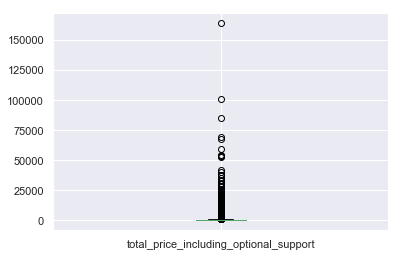

In [17]:
data['total_price_including_optional_support'].plot.box()

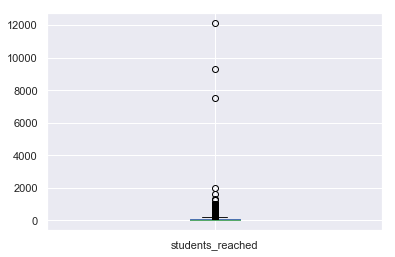

In [18]:
data['students_reached'].plot.box()

In [20]:
data['eligible_double_your_impact_match'].value_counts()

f    87887
t    37089
Name: eligible_double_your_impact_match, dtype: int64

In [35]:
# Select the features and drop the null values in the features
# Convert categories to corresponding integers in categorical variables
features = ['school_metro','school_charter', 'school_magnet', 
            'primary_focus_area', 'secondary_focus_area', 'poverty_level', 'resource_type', 'total_price_including_optional_support',
           'students_reached', 'eligible_double_your_impact_match']
to_dummies = ['school_metro', 'primary_focus_area', 'secondary_focus_area', 'resource_type', 'poverty_level']
replace_to_numbers = ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']
to_discretize = ['total_price_including_optional_support', 'students_reached']
for col in replace_to_numbers:
    data[col] = data[col].replace(['f','t'], [0,1])
data = to_dummy(data, to_dummies)
for column in to_discretize:
    fill_na(data, to_discretize)
discretize_col(data, to_discretize)

In [36]:
data.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_district', 'school_county', 'school_charter', 'school_magnet',
       'teacher_prefix', 'primary_focus_subject', 'secondary_focus_subject',
       'grade_level', 'total_price_including_optional_support',
       'students_reached', 'eligible_double_your_impact_match', 'date_posted',
       'datefullyfunded', 'over_60_days', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban',
       'primary_focus_area_Applied Learning',
       'primary_focus_area_Health & Sports',
       'primary_focus_area_History & Civics',
       'primary_focus_area_Literacy & Language',
       'primary_focus_area_Math & Science',
       'primary_focus_area_Music & The Arts',
       'primary_focus_area_Special Needs',
       'secondary_focus_area_Applied Learning',
       'secondary_focus_area_Health & Sports',
       'secondary_focus_ar

In [56]:
data_select = data[['school_charter', 'school_magnet','total_price_including_optional_support',
       'students_reached', 'eligible_double_your_impact_match', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban',
       'primary_focus_area_Applied Learning',
       'primary_focus_area_Health & Sports',
       'primary_focus_area_History & Civics',
       'primary_focus_area_Literacy & Language',
       'primary_focus_area_Math & Science',
       'primary_focus_area_Music & The Arts',
       'primary_focus_area_Special Needs',
       'secondary_focus_area_Applied Learning',
       'secondary_focus_area_Health & Sports',
       'secondary_focus_area_History & Civics',
       'secondary_focus_area_Literacy & Language',
       'secondary_focus_area_Math & Science',
       'secondary_focus_area_Music & The Arts',
       'secondary_focus_area_Special Needs', 'resource_type_Books',
       'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty','over_60_days']]
features = ['school_charter', 'school_magnet','total_price_including_optional_support',
       'students_reached', 'eligible_double_your_impact_match', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban',
       'primary_focus_area_Applied Learning',
       'primary_focus_area_Health & Sports',
       'primary_focus_area_History & Civics',
       'primary_focus_area_Literacy & Language',
       'primary_focus_area_Math & Science',
       'primary_focus_area_Music & The Arts',
       'primary_focus_area_Special Needs',
       'secondary_focus_area_Applied Learning',
       'secondary_focus_area_Health & Sports',
       'secondary_focus_area_History & Civics',
       'secondary_focus_area_Literacy & Language',
       'secondary_focus_area_Math & Science',
       'secondary_focus_area_Music & The Arts',
       'secondary_focus_area_Special Needs', 'resource_type_Books',
       'resource_type_Other', 'resource_type_Supplies',
       'resource_type_Technology', 'resource_type_Trips',
       'resource_type_Visitors', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty']
label = ['over_60_days']
data_select

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_suburban,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,over_60_days
0,0,0,2,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0,0,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,2,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
5,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
6,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
7,0,0,2,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
8,0,0,2,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
9,0,0,2,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [38]:
# Apply the k-means clustering model to the pre-processed data
X = data_select
kmeans, y_kmeans = create_clustering_model(X, 3)
cluster_map = create_cluster_map(X, kmeans)
cluster_map

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_suburban,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,...,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,over_60_days,cluster_label
0,0,0,2,1,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,2,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,2
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,0,2,2,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,2
5,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
6,0,0,1,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
7,0,0,2,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,2,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,2
9,0,0,2,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,2


In [53]:
# Find the summary statistics of cluster 0
#find_summary_stats_of_cluster(cluster_map, 0)
# Cluster 0: Projects that mainly come from schools that are non-charter non-magnet schools,
# mostly with relatively medium to large total price of support and reach to medium-to-large number of students.
# Most of the schools are in suburban and urban areas with relatively high poverty level
find_value_counts_of_cluster(cluster_map, 0)

0    33859
1     4050
Name: school_charter, dtype: int64
0    33885
1     4024
Name: school_magnet, dtype: int64
1    22682
2    10737
0     4490
Name: total_price_including_optional_support, dtype: int64
2    25932
1    11977
0        0
Name: students_reached, dtype: int64
0    25649
1    12260
Name: eligible_double_your_impact_match, dtype: int64
0    33735
1     4174
Name: school_metro_rural, dtype: int64
0    27854
1    10055
Name: school_metro_suburban, dtype: int64
1    19266
0    18643
Name: school_metro_urban, dtype: int64
0    34182
1     3727
Name: primary_focus_area_Applied Learning, dtype: int64
0    35460
1     2449
Name: primary_focus_area_Health & Sports, dtype: int64
0    35608
1     2301
Name: primary_focus_area_History & Civics, dtype: int64
0    32480
1     5429
Name: primary_focus_area_Literacy & Language, dtype: int64
0    22963
1    14946
Name: primary_focus_area_Math & Science, dtype: int64
0    29840
1     8069
Name: primary_focus_area_Music & The Arts, dtype: i

In [54]:
# Find the summary statistics of cluster 1
find_value_counts_of_cluster(cluster_map, 1)
# Cluster 1: Projects that mainly come from schools that are non-charter non-magnet schools,
# mostly with relatively low-to-medium total price of support and reach to low-to-medium number of students.
# Most of the schools are in suburban and urban areas with relatively high poverty level

0    45127
1     4520
Name: school_charter, dtype: int64
0    45716
1     3931
Name: school_magnet, dtype: int64
0    26755
1    22892
2        0
Name: total_price_including_optional_support, dtype: int64
1    28287
0    20231
2     1129
Name: students_reached, dtype: int64
0    34448
1    15199
Name: eligible_double_your_impact_match, dtype: int64
0    43573
1     6074
Name: school_metro_rural, dtype: int64
0    37459
1    12188
Name: school_metro_suburban, dtype: int64
1    24910
0    24737
Name: school_metro_urban, dtype: int64
0    46730
1     2917
Name: primary_focus_area_Applied Learning, dtype: int64
0    48883
1      764
Name: primary_focus_area_Health & Sports, dtype: int64
0    48115
1     1532
Name: primary_focus_area_History & Civics, dtype: int64
1    30979
0    18668
Name: primary_focus_area_Literacy & Language, dtype: int64
0    42196
1     7451
Name: primary_focus_area_Math & Science, dtype: int64
0    47534
1     2113
Name: primary_focus_area_Music & The Arts, dtype: i

In [55]:
# Find the summary statistics of cluster 2
find_value_counts_of_cluster(cluster_map, 2)
# Cluster 2: Projects that mainly come from schools that are non-charter non-magnet schools,
# mostly with relatively medium-to-high total price of support and reach to low-to-medium number of students.
# Most of the schools are in suburban and urban areas with relatively high poverty level

0    34354
1     3066
Name: school_charter, dtype: int64
0    34672
1     2748
Name: school_magnet, dtype: int64
2    20505
1    16915
0        0
Name: total_price_including_optional_support, dtype: int64
1    23282
0    13100
2     1038
Name: students_reached, dtype: int64
0    27790
1     9630
Name: eligible_double_your_impact_match, dtype: int64
0    33267
1     4153
Name: school_metro_rural, dtype: int64
0    26579
1    10841
Name: school_metro_suburban, dtype: int64
0    19329
1    18091
Name: school_metro_urban, dtype: int64
0    35342
1     2078
Name: primary_focus_area_Applied Learning, dtype: int64
0    37138
1      282
Name: primary_focus_area_Health & Sports, dtype: int64
0    36095
1     1325
Name: primary_focus_area_History & Civics, dtype: int64
1    19643
0    17777
Name: primary_focus_area_Literacy & Language, dtype: int64
0    28113
1     9307
Name: primary_focus_area_Math & Science, dtype: int64
0    36119
1     1301
Name: primary_focus_area_Music & The Arts, dtype: i

In [58]:
# Apply the k-means clustering model only to the observations that do not get fully-funded in 60 days
X_2 = data_select[data_select['over_60_days'] == 1]
kmeans, y_kmeans = create_clustering_model(X_2, 3)
cluster_map_2 = create_cluster_map(X_2[X_2.columns[:-1]], kmeans)
cluster_map_2

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_suburban,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,cluster_label
2,0,0,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,2,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,2
5,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
10,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1
11,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
14,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
16,0,0,1,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,2
22,0,0,2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2
23,0,0,2,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
25,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [59]:
# With the new model, find the summary statistics of cluster 0
find_value_counts_of_cluster(cluster_map_2, 0)
# Cluster 0: Projects that request relatively medium-to-high price that reach low-to-medium number of students
# and the schools are located in urban and suburban areas with the highest poverty level

0    13045
1     1172
Name: school_charter, dtype: int64
0    12994
1     1223
Name: school_magnet, dtype: int64
1    7568
2    5007
0    1642
Name: total_price_including_optional_support, dtype: int64
1    9326
0    4891
2       0
Name: students_reached, dtype: int64
0    10859
1     3358
Name: eligible_double_your_impact_match, dtype: int64
0    12835
1     1382
Name: school_metro_rural, dtype: int64
0    10922
1     3295
Name: school_metro_suburban, dtype: int64
1    8029
0    6188
Name: school_metro_urban, dtype: int64
0    13121
1     1096
Name: primary_focus_area_Applied Learning, dtype: int64
0    14014
1      203
Name: primary_focus_area_Health & Sports, dtype: int64
0    13769
1      448
Name: primary_focus_area_History & Civics, dtype: int64
1    7730
0    6487
Name: primary_focus_area_Literacy & Language, dtype: int64
0    11260
1     2957
Name: primary_focus_area_Math & Science, dtype: int64
0    13611
1      606
Name: primary_focus_area_Music & The Arts, dtype: int64
0    

In [60]:
# With the new model, find the summary statistics of cluster 1
find_value_counts_of_cluster(cluster_map_2, 1)
# Cluster 0: Projects that request relatively medium-to-high price that reach medium number of students
# and the schools are located in urban and suburban areas with relatively high poverty level

0    12325
1     1017
Name: school_charter, dtype: int64
0    12624
1      718
Name: school_magnet, dtype: int64
1    7185
2    4296
0    1861
Name: total_price_including_optional_support, dtype: int64
1    8589
0    4753
2       0
Name: students_reached, dtype: int64
0    10602
1     2740
Name: eligible_double_your_impact_match, dtype: int64
0    10820
1     2522
Name: school_metro_rural, dtype: int64
0    9168
1    4174
Name: school_metro_suburban, dtype: int64
0    8848
1    4494
Name: school_metro_urban, dtype: int64
0    12386
1      956
Name: primary_focus_area_Applied Learning, dtype: int64
0    13169
1      173
Name: primary_focus_area_Health & Sports, dtype: int64
0    12909
1      433
Name: primary_focus_area_History & Civics, dtype: int64
1    6988
0    6354
Name: primary_focus_area_Literacy & Language, dtype: int64
0    10367
1     2975
Name: primary_focus_area_Math & Science, dtype: int64
0    12781
1      561
Name: primary_focus_area_Music & The Arts, dtype: int64
0    12

In [61]:
# With the new model, find the summary statistics of cluster 2
find_value_counts_of_cluster(cluster_map_2, 2)
# Cluster 2: Projects that request relatively medium-to-high price that reach large number of students
# and the schools are located in urban and suburban areas with relatively high poverty level

0    7561
1     890
Name: school_charter, dtype: int64
0    7576
1     875
Name: school_magnet, dtype: int64
1    4013
2    3676
0     762
Name: total_price_including_optional_support, dtype: int64
2    8441
1      10
0       0
Name: students_reached, dtype: int64
0    6437
1    2014
Name: eligible_double_your_impact_match, dtype: int64
0    7284
1    1167
Name: school_metro_rural, dtype: int64
0    6022
1    2429
Name: school_metro_suburban, dtype: int64
0    4739
1    3712
Name: school_metro_urban, dtype: int64
0    7781
1     670
Name: primary_focus_area_Applied Learning, dtype: int64
0    7842
1     609
Name: primary_focus_area_Health & Sports, dtype: int64
0    7864
1     587
Name: primary_focus_area_History & Civics, dtype: int64
0    5941
1    2510
Name: primary_focus_area_Literacy & Language, dtype: int64
0    6004
1    2447
Name: primary_focus_area_Math & Science, dtype: int64
0    6934
1    1517
Name: primary_focus_area_Music & The Arts, dtype: int64
0    8340
1     111
Name:

### Top 5% of Predicted Projects Unlikely to be Fully Funded

From last homework, we recognized that the logistic regression model is the best model on predicting the projects that are not likely to be fully funded in 60 days. As a result, we use logistic regression model here to find the top 5% of the projects unlikely to be fully funded in 60 days

In [71]:
# Build the logistic regression model and train it
X = data_select[features]
y = data_select[label[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = LogisticRegression(penalty='l2',C=1.0, solver='lbfgs')
clf = clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]

In [72]:
# Find the top 5% predicted projects in the test data
pred_probs_map = pd.DataFrame()
pred_probs_map['index'] = y_test.index
pred_probs_map['probs'] = y_pred_probs
pred_probs_map = pred_probs_map.sort_values(by='probs',ascending=False)
pred_probs_map = pred_probs_map[:int(len(y_test)*0.05)]
indices_lst = []
for index in pred_probs_map['index']:
    indices_lst.append(index)
X_to_be_examined = X_test[X_test.index.isin(indices_lst)]
X_to_be_examined

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_suburban,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty
15990,0,0,2,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
42050,0,0,2,2,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
116728,0,0,2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
120255,0,0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
32586,0,0,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
55317,0,0,2,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
83314,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
79679,0,0,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
48852,0,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
28977,1,0,2,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


In [73]:
# Build a new k-means clustering model and apply it to the top 5% of the predicted projects
kmeans, y_kmeans = create_clustering_model(X_to_be_examined, 3)
cluster_map = create_cluster_map(X_to_be_examined, kmeans)
cluster_map

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_metro_rural,school_metro_suburban,school_metro_urban,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,cluster_label
15990,0,0,2,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
42050,0,0,2,2,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
116728,0,0,2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2
120255,0,0,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
32586,0,0,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
55317,0,0,2,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
83314,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
79679,0,0,2,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
48852,0,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1
28977,1,0,2,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [74]:
# With the new model, find the summary statistics of cluster 0
find_value_counts_of_cluster(cluster_map, 0)
# Cluster 0: Projects that request high price that reach medium-to-high number of students
# and the schools are located in rural and suburban areas with moderate poverty level

0    465
1     14
Name: school_charter, dtype: int64
0    469
1     10
Name: school_magnet, dtype: int64
2    479
1      0
0      0
Name: total_price_including_optional_support, dtype: int64
1    240
2    138
0    101
Name: students_reached, dtype: int64
0    476
1      3
Name: eligible_double_your_impact_match, dtype: int64
0    296
1    183
Name: school_metro_rural, dtype: int64
0    312
1    167
Name: school_metro_suburban, dtype: int64
0    432
1     47
Name: school_metro_urban, dtype: int64
0    434
1     45
Name: primary_focus_area_Applied Learning, dtype: int64
0    464
1     15
Name: primary_focus_area_Health & Sports, dtype: int64
0    462
1     17
Name: primary_focus_area_History & Civics, dtype: int64
1    318
0    161
Name: primary_focus_area_Literacy & Language, dtype: int64
0    438
1     41
Name: primary_focus_area_Math & Science, dtype: int64
0    474
1      5
Name: primary_focus_area_Music & The Arts, dtype: int64
0    441
1     38
Name: primary_focus_area_Special Need

In [75]:
# With the new model, find the summary statistics of cluster 0
find_value_counts_of_cluster(cluster_map, 1)
# Cluster 0: Projects that request high prices
# and the schools are located in suburban and urban areas with relatively high poverty level

0    809
1     54
Name: school_charter, dtype: int64
0    833
1     30
Name: school_magnet, dtype: int64
2    857
1      6
0      0
Name: total_price_including_optional_support, dtype: int64
1    398
0    237
2    228
Name: students_reached, dtype: int64
0    853
1     10
Name: eligible_double_your_impact_match, dtype: int64
0    615
1    248
Name: school_metro_rural, dtype: int64
0    592
1    271
Name: school_metro_suburban, dtype: int64
0    728
1    135
Name: school_metro_urban, dtype: int64
0    773
1     90
Name: primary_focus_area_Applied Learning, dtype: int64
0    834
1     29
Name: primary_focus_area_Health & Sports, dtype: int64
0    821
1     42
Name: primary_focus_area_History & Civics, dtype: int64
1    517
0    346
Name: primary_focus_area_Literacy & Language, dtype: int64
0    763
1    100
Name: primary_focus_area_Math & Science, dtype: int64
0    857
1      6
Name: primary_focus_area_Music & The Arts, dtype: int64
0    784
1     79
Name: primary_focus_area_Special Need

In [76]:
# With the new model, find the summary statistics of cluster 0
find_value_counts_of_cluster(cluster_map, 2)
# Cluster 0: Projects that request high prices
# and the schools are located in rural and suburban areas with the highest poverty level

0    676
1     44
Name: school_charter, dtype: int64
0    679
1     41
Name: school_magnet, dtype: int64
2    720
1      0
0      0
Name: total_price_including_optional_support, dtype: int64
1    356
2    186
0    178
Name: students_reached, dtype: int64
0    716
1      4
Name: eligible_double_your_impact_match, dtype: int64
0    533
1    187
Name: school_metro_rural, dtype: int64
0    505
1    215
Name: school_metro_suburban, dtype: int64
0    554
1    166
Name: school_metro_urban, dtype: int64
0    664
1     56
Name: primary_focus_area_Applied Learning, dtype: int64
0    711
1      9
Name: primary_focus_area_Health & Sports, dtype: int64
0    707
1     13
Name: primary_focus_area_History & Civics, dtype: int64
1    557
0    163
Name: primary_focus_area_Literacy & Language, dtype: int64
0    681
1     39
Name: primary_focus_area_Math & Science, dtype: int64
0    719
1      1
Name: primary_focus_area_Music & The Arts, dtype: int64
0    675
1     45
Name: primary_focus_area_Special Need